# Reentry Chile Response Rate

In this report I describe response rates by wave. I follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months, six_months
- Variables names: d means date, c means clean, and cd clean date
- Deadline corresponds to th time threshold to compute a given response rate

I review the key date variables to compute the rates and highlight inconsistencies or problems. 

## Release

There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validaded and unique date of release variable*. 

In [90]:
import pandas as pd
path = '/Users/sdaza/Google Drive/github/reentry-chile/reports/data/20170628 Logros.xlsx'
file = pd.ExcelFile(path)

In [91]:
df = file.parse(-1)
type(file)

df.columns = map(str.lower, df.columns)


In [92]:
# rename some variables
old_names = ['id folio', 'encuestadora final', 'fecha egreso', 'fecha egreso definitiva']
new_names = ['id', 'interviewer', 'release_o', 'release']
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
cnames = list(df.columns)

In [93]:
s = df.release.isnull()
print(s.value_counts())

False    162
True      63
Name: release, dtype: int64


In [94]:
df.loc[s, 'release'] = df.loc[s, 'release_o']

start = pd.to_datetime("09/01/2016")

s = (df.release < start) & (df.release_o >= start)
df.loc[s, ['release']] = df.loc[s, ['release_o']]

df['release_year'] = pd.DatetimeIndex(df['release']).year
df['release_month'] = pd.DatetimeIndex(df['release']).month
print(df.release_year.value_counts())
print(df.release_month.value_counts())

print(df.loc[df.release == '2016-01-01', ['id', 'release', 'release_o']])

2016.0    146
2017.0     77
Name: release_year, dtype: int64
10.0    71
12.0    34
3.0     29
1.0     28
11.0    28
2.0     20
9.0     13
Name: release_month, dtype: int64
Empty DataFrame
Columns: [id, release, release_o]
Index: []


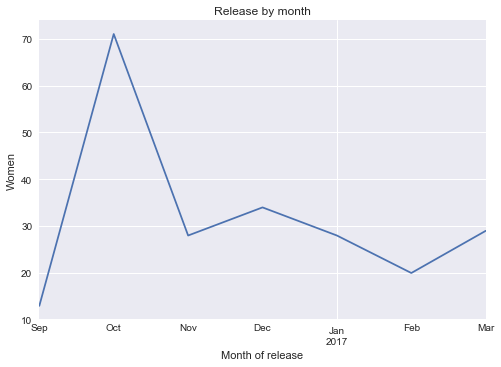

In [124]:
# plot of release
import matplotlib.pyplot as plt
plt.style.use("seaborn")

t = df.reset_index().set_index('release')
t = t.resample('M')
ax = t.id.count().plot(title='Release by month')
ax.set_ylabel("Women")
ax.set_xlabel("Month of release")
plt.show()

## Baseline

Let's explore the baseline information. 

Below a plot with the distribution of the difference between the date of the baseline and release. All values should be negative. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [96]:
# baseline response
varname = [col for col in df.columns if 'sí: se realizó línea base' in col]
print(varname)

df = df.rename(columns={varname[0]: 'r_baseline'})
df.r_baseline.value_counts()
df['r_baseline'] = df['r_baseline'].str.contains("s|S").astype(int)
df.r_baseline.value_counts()  # only ones

['participa\n\nsí: se realizó línea base\nno: no se realizó lb']


1    225
Name: r_baseline, dtype: int64

In [ ]:
# date of baseline
varname = [col for col in df.columns if 'fecha entrevista' in col]
print(varname)

df = df.rename(columns={varname[0]: 'dbaseline'})

In [105]:
import re

def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True)

df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

In [113]:
m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
df.loc[m, ['cdbaseline', 'dbaseline']]

,cdbaseline,dbaseline
43,NaT,V14 y M18/10
224,NaT,V16/12716


In [ ]:
# replace errors in data entry
errors = ['V16/12716', 'V14 y M18/10']
new_values = ['12/16/16', '10/18/16']

for i in range(0,len(errors)):
   df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i])

In [ ]:
df.cdbaseline.describe()

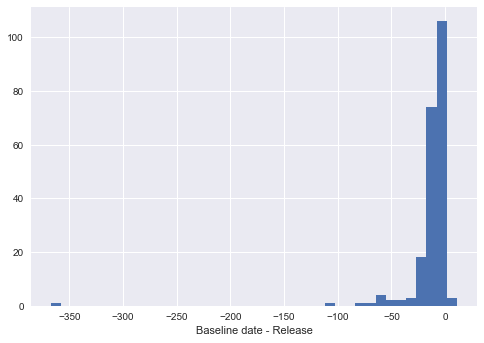

In [127]:
# identify inconsistent cases
df = df.assign(release_baseline = (df.cdbaseline - df.release).dt.days)
df.release_baseline.describe()
ax = df.release_baseline.hist(bins = 40)
ax.set_xlabel('Baseline date - Release')
plt.show()

In [129]:
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))

False    215
True      10
dtype: int64

In [141]:
df.loc[s, ['id', 'r_baseline', 'release_baseline', 'release', 'cdbaseline', 'dbaseline']].sort_values('id')

,id,r_baseline,release_baseline,release,cdbaseline,dbaseline
138,10272,1,NaN,2017-03-06,NaT,NaN
146,10282,1,NaN,2017-03-13,NaT,NaN
150,10285,1,NaN,2017-03-17,NaT,NaN
153,10288,1,NaN,2017-03-18,NaT,NaN
155,10291,1,NaN,2017-03-22,NaT,NaN
156,10293,1,NaN,2017-03-25,NaT,NaN
203,20120,1,NaN,2016-10-29,NaT,NaN
88,20200,1,5.0,2016-12-21,2016-12-26,2016-12-26 00:00:00
187,40059,1,2.0,2016-10-17,2016-10-19,W19/10/16
19,50037,1,11.0,2016-10-19,2016-10-30,2016-10-30 00:00:00


In [8]:
# function to clean dates
def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True)

df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
df.loc[m, ['cdbaseline', 'dbaseline']]

# replace errors in data entry
errors = ['V16/12716', 'V14 y M18/10']
new_values = ['16/12/16', '18/10/16']

for i in range(0,len(errors)):
   df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i], format='%d/%m/%y')

m = df['cdbaseline'].isnull()
m.value_counts()
df.loc[m, ['cdbaseline', 'dbaseline']]





print('# First week')

varname = [col for col in df.columns if 'participa' in col]
print(varname)

df = df.rename(columns={varname[1]: 'r_week'})
df.r_week.value_counts()
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
df.r_week.isnull().value_counts()
df.r_week.value_counts()

# df.loc[df.r_week==1, ['id']].sort('id')

# date week
varname = [col for col in df.columns if 'fecha entrevista' in col]
print(varname)

df = df.rename(columns={varname[0]: 'dweek'})
df.dweek.describe()

df['cdweek'] = [clean_dates(i) for i in df['dweek']]
df.cdweek.describe()

m = df.cdweek.isnull() & df.dweek.notnull()
df.loc[m, ['id', 'cdweek', 'dweek']]


# replace errors in data entry
def excel_datetime(xldate, datemode = 0):
    # datemode: 0 for 1900-based, 1 for 1904-based
    return (
        datetime.datetime(1899, 12, 30)
        + datetime.timedelta(days=xldate + 1462 * datemode)
        )


errors = ['42671', 'S29/10 y W02/11']
new_values = [excel_datetime(42671, 0), '11/02/2016']

for i in range(0,len(errors)):
   df.loc[df['dweek'] == errors[i], 'cdweek'] = pd.to_datetime(new_values[i], dayfirst=True)

s = (df.r_week == 1)
df.loc[s, 'cdweek'].isnull().value_counts()
#df.loc[s,['id', 'r_week', 'release', 'week_dealine', 'cdweek']]

df = df.assign(release_week = (df.cdweek - df.release).dt.days)
df.release_week.describe()

df.loc[df.release_week < -5000, ['id', 'r_week', 'release', 'week', 'release_week']]
df.release_week.hist()
plt.show()


df['week_deadline'] = pd.DatetimeIndex( df['release'] ) + pd.DateOffset(weeks = 5)

df.loc[df.r_week == 1, 'cdweek'].isnull().value_counts()

s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )


df.loc[s,['id', 'r_week', 'release', 'cdweek', 'week_deadline']].sort('id')


tab  = df.loc[ (today > df.week_deadline), 'r_week'].value_counts()
[i / sum(list(tab)) for i in l]

# two months

# cnames
varname = [col for col in df.columns if 'participa ' in col]
print(varname)

df = df.rename(columns={varname[0]: 'r_2months'})
df.r_2months.value_counts()
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)
df.r_2months.isnull().value_counts()
df.r_2months.value_counts()

# df.loc[df.r_2months==1, ['id']].sort('id')

# date 2months
varname = [col for col in df.columns if 'fecha entrevista' in col]
print(varname)

df = df.rename(columns={varname[0]: 'd2months'})
df.d2months.describe()

df['cd2months'] = [clean_dates(i) for i in df['d2months']]
df.cd2months.describe()

m = df.cd2months.isnull() & df.d2months.notnull()
df.loc[m, ['id', 'release', 'cd2months', 'd2months']]


# replace errors in data entry
errors = ['27/2']
new_values = ['27/02/2017']

for i in range(0,len(errors)):
   df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])

s = (df.r_2months == 1)
df.loc[s, 'cd2months'].isnull().value_counts()
#df.loc[s,['id', 'r_2months', 'release', '2months_dealine', 'cd2months']]

df = df.assign(release_2months = (df.cd2months - df.release).dt.days)
df.release_2months.describe()
df.release_2months.hist()
plt.show()


df['two_months_deadline'] = pd.DatetimeIndex( df['release'] ) + pd.DateOffset(months = 5)

df.loc[df.r_2months == 1, 'cd2months'].isnull().value_counts()

s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()) )


df.loc[s,['id', 'r_2months', 'release', 'cd2months', '2months_deadline']].sort('id')


tab  = df.loc[ (today > df.2months_deadline), 'r_2months'].value_counts()
[i / sum(list(tab)) for i in l]

pandas.io.excel.ExcelFile

In [ ]:

# define today
today = datetime.datetime.now()
start = pd.to_datetime("01/09/2017", dayfirst=True)
print(start)
